In [2]:
!python3 --version

Python 3.8.5


In [4]:
import os
import random
import numpy as np
from textgrids import TextGrid
import librosa
from librosa.display import waveplot
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf

import warnings
warnings.filterwarnings('ignore')

Text(0.5, 0.98, 'Speaker 29, Sentence 0000')

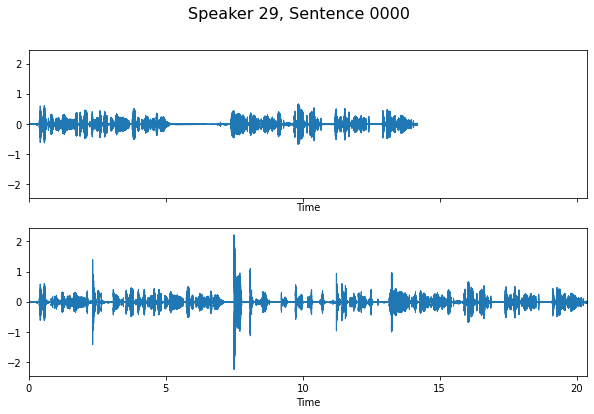

In [3]:
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(10,6))
waveplot(audio, sr=sample_rate, ax=ax[0])
waveplot(new_audio, sr=sample_rate, ax=ax[1])
fig.suptitle("Speaker 29, Sentence 0000", fontsize=16)

In [8]:
# out_file = os.path.join(augmented_data_dir,'test.wav')
# write_wav(out_file, sr, y_slow)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
# replace a filename string's extension with a new extension
def replace_extension(file, ext):
    return os.path.splitext(file)[0] + ext

# convert intervals in milliseconds to frames with 16kHz sample rate
def interval_to_frame(start, stop, sample_rate):
    return int(sample_rate*start), int(sample_rate*stop)

# group phones by words
def get_word_phone_list(grid):
    words = [word for word in grid['words']]
    word_idx = 0
    words_phones = []
    temp = []
    for phone in grid['phones']:
        word = words[word_idx]
        if phone.xmax > word.xmax:
            word_idx += 1
            words_phones.append((word, temp))
            temp = []
        else:
            temp.append(phone)
    words_phones.append((word, temp))
    return words_phones

def augment_audio(grid, audio, sample_rate):
    word_phones = get_word_phone_list(grid)
    new_audio = audio
    for word in reversed(word_phones):
        if random.randint(0, 2) == 0:
            word = word[0]
            # generate artificial stutter
            frames = interval_to_frame(word.xmin, word.xmax, sample_rate)
            silence = np.zeros(random.randint(800, 1600))
            
            stutterance = audio[frames[0]:frames[1]]
            stutterance = np.concatenate([stutterance, silence])
            stutterance = np.tile(stutterance, random.randint(1, 2))
            stutterance = librosa.effects.time_stretch(stutterance, 0.9)

            # insert stutters at start of phone interval
            new_audio = np.concatenate([new_audio[:frames[0]], stutterance, new_audio[frames[1]:]], axis=0)
            
        else:
            for phone in word[1]:
                if phone.text not in reversed(stops): # need to insert in reverse to preserve index
                    continue
                    
                # generate artificial stutter
                frames = interval_to_frame(phone.xmin, phone.xmax, sample_rate)
                silence = np.zeros(random.randint(800, 1600))

                stutterance = audio[frames[0]:frames[1]]
                stutterance = np.concatenate([stutterance, silence])
                stutterance = np.tile(stutterance, random.randint(2, 3))
                stutterance = librosa.effects.time_stretch(stutterance, 0.7)

                # insert stutters at start of phone interval
                new_audio = np.insert(new_audio, frames[0], stutterance)
    
    return new_audio

# stutter stops
stops = ['B', 'R', 'D', 'T', 'P']

# directories
aligned_data_dir = './aligned-data-big'
wave_data_dir = './librispeech-big-lab'
augmented_data_dir = './augmented-data-big'
max_speakers = 80
curr_speaker = 1
for speaker in os.listdir(aligned_data_dir):
    if curr_speaker > max_speakers:
        break

    # create speaker folder if doesn't exist
    if not os.path.exists(os.path.join(augmented_data_dir, speaker)):
        os.makedirs(os.path.join(augmented_data_dir, speaker))
    print(f"speaker {curr_speaker}: {speaker}")

    if os.path.isdir(os.path.join(aligned_data_dir, speaker)):
        for sentence in os.listdir(os.path.join(aligned_data_dir, speaker)):
            # Load sentence textgrid and wave file
            grid = TextGrid(os.path.join(aligned_data_dir, speaker, sentence))
            audio_path = os.path.join(wave_data_dir, speaker, replace_extension(sentence, '.wav'))
            audio, sample_rate = librosa.load(audio_path)
            
            # add artificial stutters
            new_audio = augment_audio(grid, audio, sample_rate)
         
            # write augmented file
            out_file = os.path.join(augmented_data_dir, speaker, replace_extension(sentence, '.wav'))
            sf.write(out_file, new_audio, sample_rate)

    curr_speaker += 1

NameError: name 'os' is not defined